In [1]:
# DIRECTORY SET
import os
import sys
from pathlib import Path
base_dir=Path(os.getcwd()).parent.parent
os.chdir(base_dir)
print(os.getcwd())

# ENVIRONMENT VARIABLES
import dotenv
dotenv.load_dotenv()

# DJANGO SETUP
import django
sys.path.append(os.path.abspath(''))
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "serverproject.settings")
django.setup()

# Import async modules
import asyncio
from asgiref.sync import sync_to_async

# Import display modules
from IPython.display import display, Markdown

# Import other modules
import faiss

# import reloading
from importlib import reload

d:\DestinyFolder\DestinyRecaps\DestinyRecapsApi\serverproject


In [2]:
%load_ext autoreload
%autoreload 2

from destinyapp.models import StreamRecapData

from destinyapp.customlibrary import services
from destinyapp.customlibrary import utils

In [3]:
# Specific imports
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from bs4 import BeautifulSoup
from collections import defaultdict
import textwrap

In [4]:
video_id="3kJr7ODrwNw"
# load the video data
stream_recap_data=await utils.get_recap_data(video_id)

In [5]:
test_text_chunks=await services.visualization.create_text_chunks(stream_recap_data.transcript, 0)

Number of chunks:  88


In [6]:
chunk_batches=await services.visualization.generate_text_chunk_batches(test_text_chunks)

In [7]:
topic_annotations_str=await services.visualization.annotate_major_minor_topics(stream_recap_data.recap)

Cost:  0.007227000000000001


In [8]:
temp_annotation_list=topic_annotations_str.split("Category: '")
major_topics=[]
for temp_annotation in temp_annotation_list:
    if "' | Context:" in temp_annotation:
        major_topic=temp_annotation.split("' | Context:")[0]
        major_topics.append(major_topic)

minor_topics=[]
temp_minor_topics=topic_annotations_str.split("Minor Topics:\n")[-1].split("- '")
for i in range(len(temp_minor_topics)):
    minor_topic=temp_minor_topics[i].strip()
    if minor_topic!="":
        minor_topics.append(minor_topic)

In [9]:
responses, annotated_results=await services.visualization.annotate_all_batches(chunk_batches, topic_annotations_str)

Cost:  0.011904000000000001
Cost:  0.013464
Cost:  0.013170000000000001
Cost:  0.013788000000000002
Cost:  0.014814
Cost:  0.014271
Cost:  0.013760999999999999
Cost:  0.014082
Cost:  0.014472


# Start of Plot 

In [10]:
def get_time_at_char_count(soup, char_count):
    cumulative_count = 0
    temp_time=""

    # Iterate through each <a> tag in the transcript
    for link in soup.find_all('a'):
        # Text inside the current <a> tag
        link_text = link.get_text()
        
        # Update the cumulative count of characters by adding the length of the current link's text
        cumulative_count += len(link_text)
        
        # Check if the cumulative character count has reached or exceeded the specified character count
        if link.get('href') is not None:
            temp_time=link['href'].split("t=")[-1].split("s")[0]
        if cumulative_count >= char_count:
            # Return the URL (href attribute) of the current <a> tag
            return int(temp_time)
        
    return int(temp_time)

def wrap_text_plot_with_outline(ax, text, x, y, width, fontsize=12, text_color='white', outline_color='black', outline_width=2, **kwargs):
    """
    Plot wrapped text with an outline in matplotlib.
    
    :param ax: Matplotlib axes object
    :param text: String to be wrapped and plotted
    :param x: X-coordinate for the text
    :param y: Y-coordinate for the text
    :param width: Maximum width of text in characters
    :param fontsize: Font size for the text (default: 12)
    :param text_color: Color of the main text (default: 'white')
    :param outline_color: Color of the text outline (default: 'black')
    :param outline_width: Width of the outline in points (default: 2)
    :param **kwargs: Additional keyword arguments for plt.text()
    """
    wrapped_text = textwrap.fill(text, width=width)
    
    # Create outline by plotting text multiple times with small offsets
    for x_offset in [-outline_width, outline_width]:
        for y_offset in [-outline_width, outline_width]:
            ax.text(x + x_offset/100, y + y_offset/100, wrapped_text, 
                    fontsize=fontsize, color=outline_color, **kwargs)
    
    # Plot the main text on top
    ax.text(x, y, wrapped_text, fontsize=fontsize, color=text_color, **kwargs)

soup = BeautifulSoup(stream_recap_data.linked_transcript, 'html.parser')

# Get the category segments
category_segments=[]
for i, annotated_segment in enumerate(annotated_results):
    category=annotated_segment["category"]
    content=annotated_segment["annotation"]
    category_segments.append(category)

# Fix min topic annotations
for i, color_segment in enumerate(category_segments):
    if color_segment not in major_topics:
        if color_segment=="non categorized":
            category_segments[i]="non categorized"
        else:
            category_segments[i]="minor topic"


# Get the widths of the segments
category_and_width_segments=[]
for i, annotated_segment in enumerate(category_segments):
    width=get_time_at_char_count(soup, (i+1)*999)-get_time_at_char_count(soup, i*1000)
    category_and_width_segments.append([annotated_segment, width])
    print(f"Segment {i}: {annotated_segment}, {width}")



# Create the segments
color_dict={
    "minor topic": "yellow",
    "non categorized": "black"
}
major_topic_color_list=[
    "green",
    "blue",
    "purple",
    "orange",
    "red",
]
for i, mt in enumerate(major_topics):
    color_dict[mt]=major_topic_color_list[i]
segments=[]
for category, width in category_and_width_segments:
    segment={"category": category, "width": width, "color": color_dict[category]}
    segments.append(segment)

# Normalize Widths
total_width=0
total_width_circle=0
for segment in segments:
    total_width+=segment["width"]
    if segment["category"]!="non categorized":
        total_width_circle+=segment["width"]

# Normalize circle widths
circle_mutlipler=total_width/total_width_circle
width_mutliplier=10/total_width
for segment in segments:
    segment["width"]=segment["width"]*width_mutliplier

# get average location of each segment category
category_locations={}
x_location=0
for i, segment in enumerate(segments):
    if segment["category"]!="non categorized":
        temp_locations=category_locations.get(segment["category"], [])
        temp_locations.append(segment["width"]/2+x_location)
        category_locations[segment["category"]]=temp_locations
    else:
        category_locations[segment["category"]]=10

    x_location+=segment["width"]

# for each segment, get the average location of the category
for category_location in category_locations:
    category_locations[category_location]=np.mean(category_locations[category_location])
category_locations=dict(sorted(category_locations.items(), key=lambda item: item[1]))

Segment 0: Content Creation and Streaming, 188
Segment 1: Content Creation and Streaming, 158
Segment 2: Technical Discussions, 108
Segment 3: Technical Discussions, 125
Segment 4: Content Creation and Streaming, 203
Segment 5: minor topic, 226
Segment 6: Platform Issues, 84
Segment 7: Political Commentary, 51
Segment 8: Content Creation and Streaming, 79
Segment 9: Political Commentary, 40
Segment 10: Personal and Relationship Topics, 59
Segment 11: Content Creation and Streaming, 53
Segment 12: Political Commentary, 55
Segment 13: Content Creation and Streaming, 78
Segment 14: minor topic, 59
Segment 15: Political Commentary, 64
Segment 16: minor topic, 80
Segment 17: Political Commentary, 124
Segment 18: Political Commentary, 97
Segment 19: Personal and Relationship Topics, 39
Segment 20: Personal and Relationship Topics, 78
Segment 21: Personal and Relationship Topics, 98
Segment 22: Personal and Relationship Topics, 63
Segment 23: non categorized, 73
Segment 24: non categorized, 7

In [11]:
# Convert the adjacent segments of the same category into one segment
temp_segments=[]
prev_segment=segments[0]
temp_width=prev_segment["width"]
for segment in segments[1:]:
    if prev_segment["category"]!=segment["category"]:
        prev_segment["width"]=temp_width
        temp_segments.append(prev_segment)
        temp_width=0
    temp_width+=segment["width"]
    prev_segment=segment
if prev_segment["category"]==segment["category"]:
    prev_segment["width"]=temp_width
    temp_segments.append(prev_segment)
segments=temp_segments

# PLOT FUNCTION

Total width: 10.000000000000002
Circle current x: 1.633444097543231
Circle current x: 2.871562368870015
Circle current x: 4.3503940764766575
Circle current x: 5.783192151285114
Circle current x: 7.303236766019364
Circle current x: 8.661557655530643


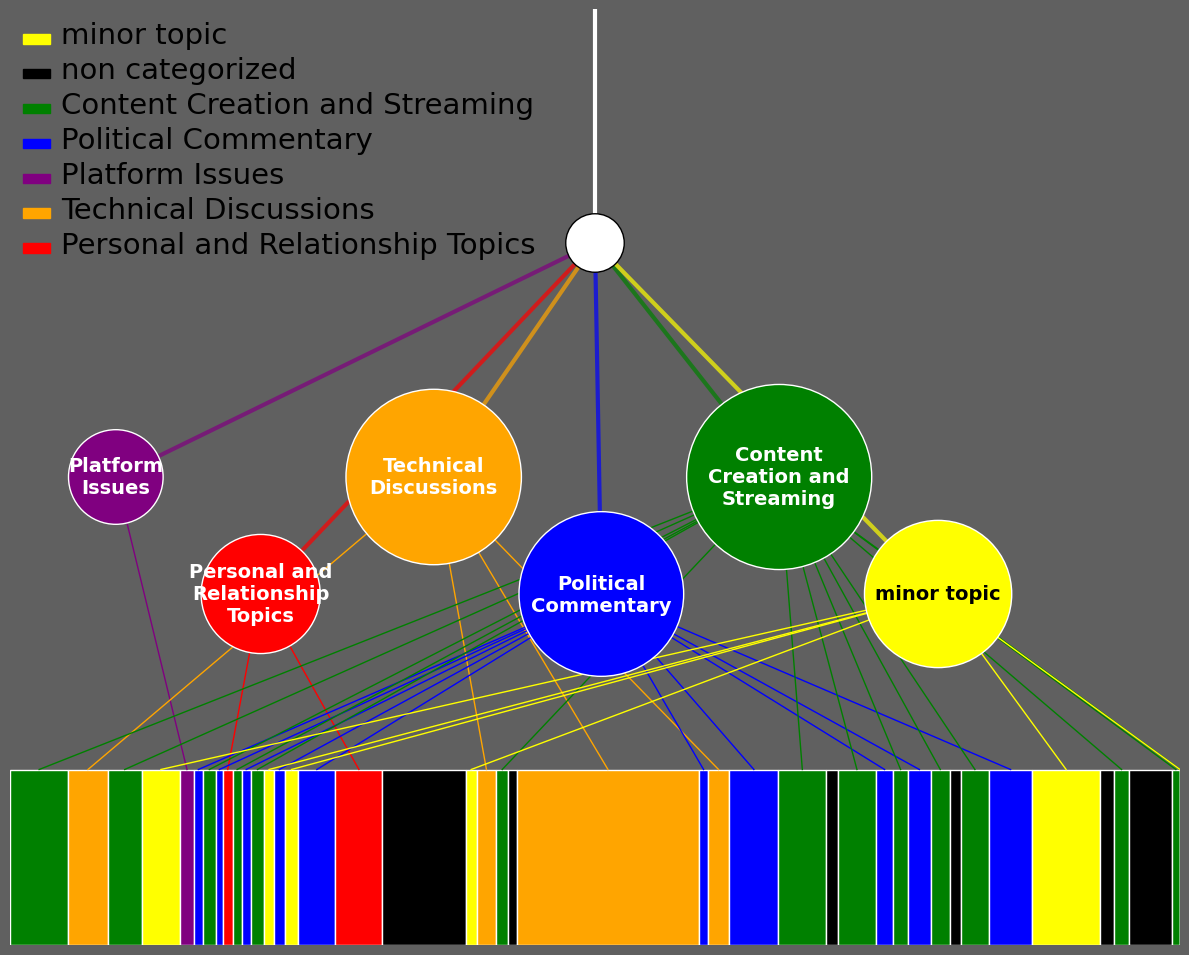

In [12]:
# Create the plot with a specific gray background
fig, ax = plt.subplots(figsize=(12, 10))
fig.patch.set_facecolor('#606060')  # Set figure background to [96, 96, 96]
ax.set_facecolor('#606060')  # Set axes background to [96, 96, 96]
target_plot_width=10


# Plot BAR 
current_x = 0
category_info = defaultdict(lambda: {"total_width": 0, "segments": []})

bar_height = 1.5

for i, segment in enumerate(segments):
    ax.add_patch(plt.Rectangle((current_x, 0), segment['width'], bar_height, 
                               facecolor=segment['color'], edgecolor='white'))
    category_info[segment['category']]['total_width'] += segment['width']
    category_info[segment['category']]['segments'].append((current_x, segment['width']))
    category_info[segment['category']]['color'] = segment['color']
    
    current_x += segment['width']

total_width = current_x
print("Total width:", total_width)







# sort category items by the same order as the category_locations
category_info=dict(sorted(category_info.items(), key=lambda item: category_locations[item[0]]))


# Calculate Circle Padding
circle_zone_size=9
circle_y = 3.5
circle_size_variable = 0.15

current_x=(target_plot_width-circle_zone_size)/2
circle_x_locations={}
total_circles_width=0
def get_circle_width(total_width):
    return (((np.sqrt(total_width) * circle_size_variable)*2)+0.3)

for category, info in category_info.items():
    if category == 'non categorized':
        pass
    else:
        circle_width=get_circle_width(info['total_width'])
        circle_x_locations[category]=circle_width
        total_circles_width+=circle_width
number_of_circles=len(circle_x_locations)
between_circle_padding=(circle_zone_size-total_circles_width)/(number_of_circles+1.15)



alterating_bool=False
vertical_offset=0
circle_centers = []
for category, info in category_info.items():
    if category == 'non categorized':
        continue

    circle_applied_size=get_circle_width(info['total_width'])

    # Calculate x position for the circle (center of all segments of this category)
    circle_x = current_x + circle_applied_size
    if alterating_bool:
        alterating_bool=False
        vertical_offset=-0.5
    else:
        vertical_offset=0.5
        alterating_bool=True

    # Store circle center, color, and size for later use
    circle_size = np.sqrt(info['total_width']) * circle_size_variable
    circle_applied_y=circle_y+vertical_offset
    circle_centers.append((circle_x, circle_applied_y, info['color'], circle_size))
    
    # DRAW LINES
    for segment_start, segment_width in info['segments']:
        segment_center = segment_start + segment_width / 2
        ax.plot([segment_center, circle_x], [bar_height, circle_applied_y], 
                color=info['color'], linewidth=1)  
        
    # PLOT CIRCLES
    circle = plt.Circle((circle_x, circle_applied_y), circle_applied_size, 
                        facecolor=info["color"], edgecolor='white', zorder=10)
    ax.add_artist(circle)

    # PLOT CIRCLE LABELS, set width to circle size and wrap
    text_wrap=textwrap.fill(category, width=12)
    bubble_font_size_text=14
    if info["color"]=="yellow":
        # make it bold and have a white border
        ax.text(circle_x, circle_applied_y, text_wrap, ha='center', va='center', color='black', fontsize=bubble_font_size_text, zorder=11, fontweight='bold')#, bbox=dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.2'))
    else:
        ax.text(circle_x, circle_applied_y, text_wrap, ha='center', va='center', color='white', fontsize=bubble_font_size_text, zorder=11, fontweight='bold')

    # current_x += (info['total_width']*circle_mutlipler)+0.1
    current_x +=between_circle_padding+circle_applied_size
    print("Circle current x:", current_x)



# Add central white circle
central_y = 6
central_circle = plt.Circle((total_width/2, central_y), 0.25, 
                            facecolor='white', edgecolor='black', zorder=12)
ax.add_artist(central_circle)

# Connect category circles to central circle with colored lines
for circle_x, circle_y, color, circle_size in circle_centers:
    ax.plot([circle_x, total_width/2], [circle_y, central_y], 
            color=color, linewidth=3, linestyle='-', alpha=0.7, zorder=9)  # Increased linewidth

# Add white line extending upward from central circle
top_y = 100  # Adjust this value to change the length of the line
ax.plot([total_width/2, total_width/2], [central_y, top_y], 
        color='white', linewidth=3, solid_capstyle='round')  # Added white line

# Customize the plot
ax.set_xlim(0, total_width)
ax.set_ylim(0, 8)
ax.set_aspect('equal', adjustable='box')
ax.axis('off')

# Add a Legend
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in color_dict.values()]
legend_labels = list(color_dict.keys())
ax.legend(legend_handles, legend_labels, loc='upper left', frameon=False)
# increase legend font size
plt.setp(ax.get_legend().get_texts(), fontsize='21')



plt.tight_layout()
plt.savefig('segment_central_hub_chart.png', dpi=300, bbox_inches='tight')
plt.show()